In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)


In [6]:
csv_path = "player_data.csv"
df = pd.read_csv(csv_path)
df.head()


,_id,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,...,E_PACE,AST_RATIO,DIST,AST_TOV,FTA_RATE,OPP_FTA_RATE,MIN,PACE_PER40,PACE,PIE
0,6257e8a35ccc080408fc781f,21500395,2015-12-18,1610612762,UTA,Utah,202353,Tibor Pleiss,Tibor,NaN,...,0.00,0.0,0.00,0.0,0.000,0.000,0.00,0.00,0.00,0.000
1,6257e8a35ccc080408fc7814,21500395,2015-12-18,1610612762,UTA,Utah,1626168,Trey Lyles,Trey,F,...,87.14,12.5,1.76,1.0,0.333,0.372,26.06,72.03,86.44,0.094
2,6257e8a35ccc080408fc7815,21500395,2015-12-18,1610612762,UTA,Utah,202324,Derrick Favors,Derrick,C,...,86.71,0.0,2.39,0.0,0.291,0.267,35.27,71.65,85.98,0.020
3,6257e8a35ccc080408fc7807,21500395,2015-12-18,1610612743,DEN,Denver,201568,Danilo Gallinari,Danilo,F,...,90.37,14.3,2.22,0.0,0.233,0.377,33.43,75.93,91.11,0.050
4,6257e8a35ccc080408fc7810,21500395,2015-12-18,1610612743,DEN,Denver,203123,Kostas Papanikolaou,Kostas,NaN,...,96.36,0.0,0.87,0.0,0.733,0.294,11.28,78.49,94.19,0.000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255914 entries, 0 to 255913
Columns: 115 entries, _id to PIE
dtypes: float64(65), int64(43), object(7)
memory usage: 224.5+ MB


In [9]:
pos_col = "START_POSITION"

df[pos_col].value_counts(dropna=False).head()


START_POSITION
NaN    157651
F       39306
G       39305
C       19652
Name: count, dtype: int64

In [10]:
def simplify_position(pos_raw):
    if pd.isna(pos_raw):
        return np.nan
    p = str(pos_raw).upper()
    if "PG" in p or "SG" in p or "G" in p:
        return "G"
    if "C" in p:
        return "C"
    if "SF" in p or "PF" in p or "F" in p:
        return "F"
    return np.nan

df["broad_pos"] = df[pos_col].apply(simplify_position)
df["broad_pos"].value_counts(dropna=False)


broad_pos
NaN    157651
F       39306
G       39305
C       19652
Name: count, dtype: int64

In [11]:
df_cls = df.dropna(subset=["broad_pos"]).copy()
df_cls["broad_pos"].value_counts(normalize=True)


broad_pos
F    0.400008
G    0.399998
C    0.199994
Name: proportion, dtype: float64

In [19]:
df_cls = df.dropna(subset=["START_POSITION"]).copy()

feature_cols = [
    "PTS",
    "AST",
    "REB",
    "DREB",
    "OREB",
    "STL",
    "BLK",
    "FG_PCT",
    "FG3_PCT",
    "FT_PCT",
    "USG_PCT",
    "TS_PCT"
]

df_cls = df_cls.dropna(subset=feature_cols + ["START_POSITION"]).copy()

X = df_cls[feature_cols]
y = df_cls["START_POSITION"]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((68784, 12), (29479, 12))

In [21]:
log_reg_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        multi_class="multinomial",
        max_iter=500,
        n_jobs=-1
    ))
])

log_reg_clf.fit(X_train, y_train)

y_pred_lr = log_reg_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report (Logistic Regression):\n")
print(classification_report(y_test, y_pred_lr))


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.6529054581227315

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

           C       0.68      0.56      0.61      5896
           F       0.58      0.61      0.59     11792
           G       0.72      0.74      0.73     11791

    accuracy                           0.65     29479
   macro avg       0.66      0.64      0.65     29479
weighted avg       0.65      0.65      0.65     29479



In [22]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.6439160080056989

Classification Report (Random Forest):

              precision    recall  f1-score   support

           C       0.66      0.58      0.62      5896
           F       0.58      0.59      0.58     11792
           G       0.71      0.73      0.72     11791

    accuracy                           0.64     29479
   macro avg       0.65      0.63      0.64     29479
weighted avg       0.64      0.64      0.64     29479



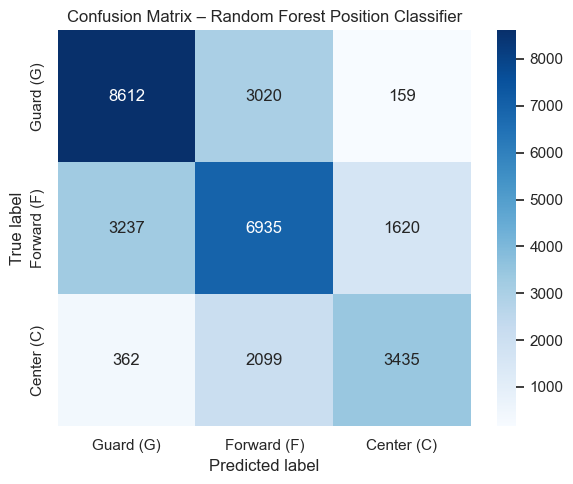

In [23]:
cm = confusion_matrix(y_test, y_pred_rf, labels=["G", "F", "C"])

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Guard (G)", "Forward (F)", "Center (C)"],
    yticklabels=["Guard (G)", "Forward (F)", "Center (C)"]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Random Forest Position Classifier")
plt.tight_layout()
plt.show()


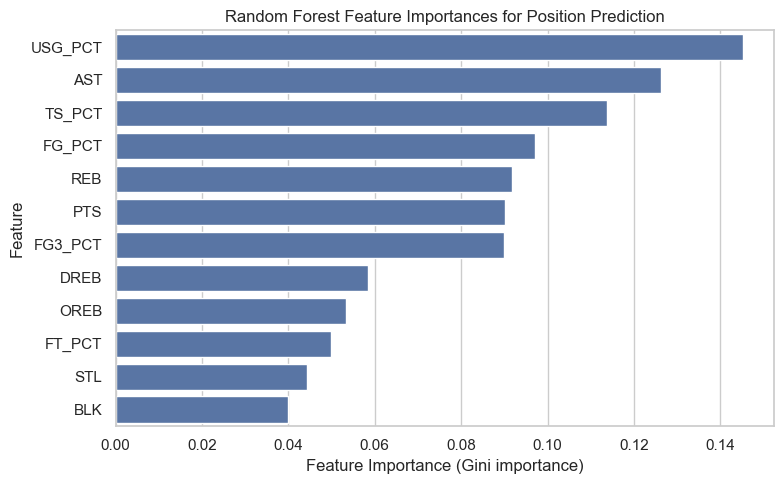

In [24]:
importances = rf_clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
sns.barplot(
    x=importances[sorted_idx],
    y=np.array(feature_cols)[sorted_idx]
)
plt.xlabel("Feature Importance (Gini importance)")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances for Position Prediction")
plt.tight_layout()
plt.show()
